In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import numpy as np
%matplotlib inline

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')

0. Базовое изучение имеющихся данных

Использую некоторые функции для верхнеуровневого изучения данных: сколько всего, сколько значений может применяться, есть ли пропущенные значения

In [3]:
customers.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [4]:
orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [5]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [6]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [7]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [8]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [9]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [10]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [11]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

# 1. Сколько у нас пользователей, которые совершили покупку только один раз?

1.1 Определение покупки. Предположим, что покупка - получение оплаты от клиента Компанией и отправка ему товара. Т.о., сначала необходимо исключить заказы, по которым не было оплаты. 

1.2 Также известно, что существуют два разных id для клиентов - customer_id и customer_unique_id. По условию, customer_unique_id аналогичен номеру паспорта, поэтому агрегировать покупки логично именно по этому id. 

1.3 Для расчета n клиентов, сделавших 1 покупку необходимо отфильтровать заказы с обозначенными статусами и посчитать их, сгруппировав с уникальным номером клиента (customer_unique_id). Для этого необходимо объединить таблицы по единому ключу. 

In [12]:
#проверка, что для одного customer_unique_id может быть более 1 customer_id
customers.groupby('customer_unique_id', as_index = False) \
    .agg({'customer_id':'count'}) \
    .sort_values('customer_id') \
    .query('customer_id != 1')

,customer_unique_id,customer_id
54375,910240400459e4edf250cddd2588bfd2,2
17957,2fa63db193ecb500d4058cae36026f8f,2
76770,cc492df9ae61715ec0ede787f6f086d9,2
48765,8194a6cea93c5c653e7956f0b962b5f7,2
76570,cbc71e02efb1d43b84f80b2a64d6013c,2
...,...,...
76082,ca77025e7201e3b30c44b472ff346268,7
37797,6469f99c1f9dfae7733b25662e7f1782,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
23472,3e43e6105506432c953e165fb2acf44c,9


In [13]:
# фильтр оплаченных заказов
orders_approved = orders[orders['order_approved_at'].notnull()]

In [14]:
# вывод статусов оставшихся заказов
orders_approved.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'approved'], dtype=object)

Вызывают сомнения оплаченные заказы двух статусов: unavailable и canceled.
По последнему можно предполложить, что клиент отменил заказ и ждет возврата средств, поэтому логично убрать такие заказы из покупок. Стоить проверить unavailable заказы: 

In [15]:
orders_approved.query('order_status == "unavailable"').head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00
1160,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaN,NaN,2017-10-27 00:00:00


На основе имеющихся данных нельзя точно сказать, что это это за заказы со статусом unavailable и почему они имеют такой статус. 
В данном проекте решено убрать оплаченные заказы в статусе unavailable из-за нехватки понимания по ним. Они также не составляют существенную часть заказов (609 шт.)

In [16]:
# датафреймы объединяются по единому ключу, после чего группирую по уникальному номеру клиента и считаю кол-во заказов
# финальный фильтр убирает клиентов, совершивших > 1 покупок
orders_approved.query('order_status != ["canceled", "unavailable"]') \
    .merge(customers[['customer_unique_id', 'customer_id']]) \
    .groupby('customer_unique_id', as_index = False) \
    .agg({'order_id': 'count'}) \
    .query('order_id == 1')

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
94968,fffcf5a5ff07b0908bd4e2dbc735a684,1
94969,fffea47cd6d3cc0a88bd621562a9d061,1
94970,ffff371b4d645b6ecea244b27531430a,1
94971,ffff5962728ec6157033ef9805bacc48,1


### Ответ 1:
Согласно описанной логики определения покупки, только одну покупку совершили **92 087 клиентов**.

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

2.1 Необходимо выбрать заказы, которые не были доставлены из таблицы orders.

2.2 Определить причины, по которым заказы могли быть не доставлены

2.3 Посчитать среднее количество недоставленных заказов по причинам в месяц

2.4 (факультативно) построить график недоставленных заказов по по причинам по месяцам

In [17]:
# вывод статусов не доставленных товаров (причин)
orders[orders['order_delivered_customer_date'].isnull()].order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

Часть заказов не являются доставленными, т.к. находятся непосредственно в процессе (едут, собираются, ждут оплаты, т.п.)
Однако вызывают сомнение заказы в статусе "delivered", но по которым нет даты фактической доставки клиенту.

In [18]:
# вывод заказазов без даты доставки, но имеющие статус "delivered"
orders[orders['order_delivered_customer_date'].isnull()].query("order_status == 'delivered'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaN,2017-12-18 00:00:00
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaN,2018-07-16 00:00:00
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaN,2018-07-30 00:00:00
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaN,2018-07-24 00:00:00
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaN,NaN,2017-06-23 00:00:00
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaN,2018-06-26 00:00:00
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaN,2018-07-19 00:00:00


Всего 8 заказов имеют статус доставленных при отсутствии даты доставки клиенту. Предположим это ошибка системы или нехватка вводной информации. 

Для дальнейшей аналитики оставим недоставленные заказы двух статусов:canceled и unavailable. 
delivered исключается по причине, описанной выше; остальные статусы нельзя считать причиной недоставки товара, т.к. они находятся еще в процессе сбора/пути.

In [19]:
# вывод недоставленных заказов по определенным выше статусам
orders_not_delivered = orders[orders['order_delivered_customer_date'].isnull()] \
    .query("order_status == ['canceled', 'unavailable']")

In [20]:
# вывод месяцев заказа для дальнейшей группировки для условия задания
orders_not_delivered['purchase_month'] = pd.DatetimeIndex(orders_not_delivered['order_purchase_timestamp']).month

In [21]:
# перевод месяца в более читаемый вид
orders_not_delivered['purchase_month'] = orders_not_delivered['purchase_month'].apply(lambda x: calendar.month_abbr[x])

In [22]:
orders_not_delivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_month
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,Nov
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaN,NaN,2018-08-14 00:00:00,Aug
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,Jan
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaN,2018-02-22 00:00:00,Jan
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,Aug


In [23]:
#подготовка данных для построения графика по недоставленным заказам по месяцам
not_delivered_by_month = orders_not_delivered.groupby(['purchase_month', 'order_status'], as_index = False ) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'not_delivered_orders'})

[Text(0.5, 0, 'Месяц заказа'), Text(0, 0.5, 'Недоставленные заказы, шт.')]

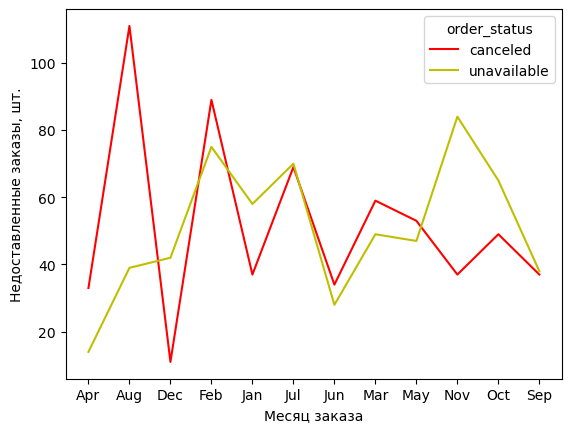

In [24]:
not_delivered_chart = sns.lineplot(x=not_delivered_by_month.purchase_month,
             y=not_delivered_by_month.not_delivered_orders,
             hue=not_delivered_by_month.order_status,
             palette = ['r', 'y']) 
not_delivered_chart.set(xlabel='Месяц заказа', ylabel='Недоставленные заказы, шт.') #установка новых названий осей

In [29]:
round(not_delivered_by_month.groupby('order_status', as_index = False).not_delivered_orders.mean(),2)

,order_status,not_delivered_orders
0,canceled,51.58
1,unavailable,50.75


### Ответ 2
Среднее по причине отмены заказа: **51.58**

Среднее по причине неизвестного статуса заказа: **50.75**

# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Для задания будет использоваться таблица с состоявшимися покупками, определение которых дано в задании 1

In [30]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [31]:
purchases = orders_approved.query('order_status != ["canceled", "unavailable"]')

In [32]:
# перевод даты оплаты заказа в формат даты 
purchases['order_approved_at'] = pd.to_datetime(orders.order_approved_at)

C:\Users\Evgeniy\AppData\Local\Temp\ipykernel_4100\2996559951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['order_approved_at'] = pd.to_datetime(orders.order_approved_at)


In [33]:
# добавление колонки с днем недели на основе даты оплаты заказа (покупки)
purchases['weekday'] = purchases['order_approved_at'].dt.day_name() 

C:\Users\Evgeniy\AppData\Local\Temp\ipykernel_4100\2319884350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['weekday'] = purchases['order_approved_at'].dt.day_name()


In [34]:
# добавляем код товара к таблице с покупками для дальнейших расчетов
purchases_w_products = purchases.merge(items[['product_id', 'order_id']])

In [35]:
# формирование df с группировкой по продукту, дню недели и количеству продаж
purchases_per_day = purchases_w_products.groupby(['product_id', 'weekday'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'sales_per_day'})

In [36]:
purchases_per_day.head()

,product_id,weekday,sales_per_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [37]:
# вывод дня недели с максимальным количеством продаж для каждого продукта
each_product_max = purchases_per_day.loc[purchases_per_day.groupby('product_id')['sales_per_day'].idxmax()]

In [38]:
each_product_max.sort_values('sales_per_day', ascending = False)

,product_id,weekday,sales_per_day
40850,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20036,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15844,422879e10f46682990de24d770e7f83d,Tuesday,89
36363,99a4788cb24856965c36a24e339b6058,Tuesday,82
12996,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23524,628cfb8a45c95a7b796ea06b006e9384,Saturday,1
23521,628b17449083fb34688b2959b80bdecd,Friday,1
23519,62892a47bea324c325a4556b66baef9d,Friday,1
23518,62874f62bbdeec35f7cd827b1716c47e,Wednesday,1


### Ответ 3:
df each_product_max

# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

4.1 Посчитать покупки по пользователям в месяц

4.2 Посчитать количество недель в месяце

4.3 Посчитать среднее количество покупок в неделю по месяцу для каждого покупателя

In [39]:
# сохраним df с покупками согласно логике 1-го задания
# сразу также добавим уникальный код клиента для будущих рассчетов
purchases_all = orders_approved.query('order_status != ["canceled", "unavailable"]') \
    .merge(customers[['customer_unique_id', 'customer_id']])

In [40]:
# переведем дату покупки в формат даты для дальнейших вычислений с ней
purchases_all['order_approved_at'] = pd.to_datetime(purchases_all.order_approved_at)

In [41]:
# сохраним df с количеством покупок по клиентам и месяцам
purchases_all_per_month = purchases_all.groupby(['customer_unique_id', 'order_approved_at'], as_index = False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'sales_per_month'})

In [42]:
purchases_all_per_month['order_approved_at'] = pd.to_datetime(purchases_all_per_month.order_approved_at)

In [43]:
# найдем количество дней в каждом месяце, чтобы посчитать среднее согласно условию задания
purchases_all_per_month['days_in_month'] = purchases_all_per_month.order_approved_at.dt.days_in_month

In [44]:
# найдем количество недель в каджом месяце
purchases_all_per_month['weeks_per_month'] = purchases_all_per_month.days_in_month / 7

In [45]:
# посчитаем среднее количество покупок в неделю для каждого клиента в каждом месяце
purchases_all_per_month['avg_sales_per_week'] = (purchases_all_per_month.sales_per_month / purchases_all_per_month.weeks_per_month) \
    .round(3)

In [46]:
purchases_all_per_month['month'] = purchases_all_per_month.order_approved_at.dt.month

In [47]:
purchases_all_per_month['month'] = purchases_all_per_month['month'] \
    .apply(lambda x: calendar.month_abbr[x])

[Text(0.5, 0, 'Месяц заказа'), Text(0, 0.5, 'Avg покупки в неделю, шт.')]

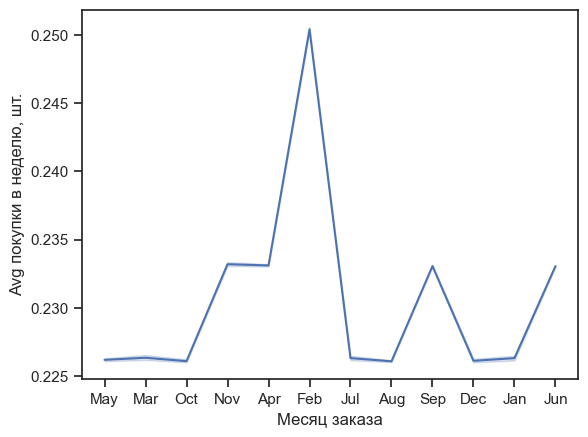

In [48]:
avg_sales_per_customer_per_week = sns.lineplot(x=purchases_all_per_month.month,
             y=purchases_all_per_month.avg_sales_per_week)
            
avg_sales_per_customer_per_week.set(xlabel='Месяц заказа', ylabel='Avg покупки в неделю, шт.')

In [49]:
purchases_all_per_month.head(10)

,customer_unique_id,order_approved_at,sales_per_month,days_in_month,weeks_per_month,avg_sales_per_week,month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 11:11:18,1,31,4.428571,0.226,May
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 18:25:44,1,31,4.428571,0.226,May
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,1,31,4.428571,0.226,Mar
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:49:17,1,31,4.428571,0.226,Oct
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 20:06:52,1,30,4.285714,0.233,Nov
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:48:59,1,30,4.285714,0.233,Apr
6,00050ab1314c0e55a6ca13cf7181fecf,2018-04-25 03:51:13,1,30,4.285714,0.233,Apr
7,00053a61a98854899e70ed204dd4bafe,2018-02-28 11:32:42,1,28,4.000000,0.250,Feb
8,0005e1862207bf6ccc02e4228effd9a0,2017-03-04 23:43:26,1,31,4.428571,0.226,Mar
9,0005ef4cd20d2893f0d9fbd94d3c0d97,2018-03-12 15:38:46,1,31,4.428571,0.226,Mar


### Ответ 4: 
df - purchases_task4_per_month, колонка - avg_sales_per_week

# 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [50]:
# уберем ненужные для расчета колонки
purchases_coh = purchases_all.drop(columns=['order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date', 
                                   'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [51]:
purchases_coh.head()

,order_id,customer_id,order_approved_at,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6


In [52]:
# перевод даты оплаты в формат даты для вычислений
purchases_coh['purchase_date'] = purchases_coh['order_approved_at'].dt.date

In [53]:
purchases_coh['year'] = purchases_coh.order_approved_at.dt.year

In [54]:
purchases_coh = purchases_coh.query('year == 2017')

In [55]:
# сгруппируем покупки по дате и идентификатору клиента
purchases_coh_count = purchases_coh.groupby(['purchase_date', 'customer_unique_id']) \
    .agg({'order_id':'count'}) \
    .reset_index() \
    .rename(columns={'order_id':'purchase_count'})

In [56]:
purchases_coh_count.head()

,purchase_date,customer_unique_id,purchase_count
0,2017-01-05,4b3207464f5f7a48a7f63fa0b1251d86,1
1,2017-01-05,b88b78a413e70182e18b032361b24f91,1
2,2017-01-05,f7b981e8a280e455ac3cbe0d5d171bd1,1
3,2017-01-06,318b69202a96429368680f215843340d,1
4,2017-01-06,48368b31672665cca1b8a03047a1702a,1


In [57]:
purchases_coh_count['purchase_date'] = pd.to_datetime(purchases_coh_count.purchase_date)

In [58]:
purchases_coh_count['purchase_date'] = purchases_coh_count['purchase_date'].apply(lambda x: datetime.date(x.year, x.month,1))

In [59]:
# добавим столбец даты привлечения клиента на основе даты первой покупки
purchases_coh_count['acq_month'] = purchases_coh_count.groupby('customer_unique_id')['purchase_date'].transform('min')

In [60]:
purchases_coh_count.loc[purchases_coh_count['purchase_date'] != purchases_coh_count['acq_month']].head()

,purchase_date,customer_unique_id,purchase_count,acq_month
730,2017-02-01,325e19085f3017b73be3d9fd98a93301,1,2017-01-01
1286,2017-02-01,c76762dfb642ac154475239639f7f8f4,1,2017-01-01
1358,2017-02-01,a7bbfaf8a288c45dc38d4693535dd63f,1,2017-01-01
2375,2017-02-01,5c82413b70d65c90e4f9e465c303fc82,1,2017-01-01
2425,2017-03-01,318b8659483e12e9cbe1e6550d97f9d9,1,2017-02-01


In [61]:
# функция для рассчета периодов между датой последней транзакции и даты привлечения клиента
def diff_month(x):
    date_1 = x['purchase_date']
    date_2 = x["acq_month"]
    return ((date_1.year - date_2.year) * 12 + date_1.month - date_2.month) + 1 # начинаем рассчет с 1 периода

purchases_coh_count['cohort_idx'] = purchases_coh_count.apply(lambda x: diff_month(x), axis=1) # посчитать ф-ию для всех строк
purchases_coh_count.head()

,purchase_date,customer_unique_id,purchase_count,acq_month,cohort_idx
0,2017-01-01,4b3207464f5f7a48a7f63fa0b1251d86,1,2017-01-01,1
1,2017-01-01,b88b78a413e70182e18b032361b24f91,1,2017-01-01,1
2,2017-01-01,f7b981e8a280e455ac3cbe0d5d171bd1,1,2017-01-01,1
3,2017-01-01,318b69202a96429368680f215843340d,1,2017-01-01,1
4,2017-01-01,48368b31672665cca1b8a03047a1702a,1,2017-01-01,1


In [62]:
# функция для создания матрицы с когортами
def get_cohort_matrix(data, var='customer_unique_id', fun=pd.Series.nunique):
    cd = data.groupby(['acq_month', 'cohort_idx'])[var].apply(fun).reset_index() # добавить даты и когорты для матрицы
    cc = cd.pivot_table(index = 'acq_month', columns = 'cohort_idx', values = var) # наполнить матрицу значениями количества
    cs = cc.iloc[:,0] # выбор 1-й колонки 
    retention = cc.divide(cs, axis = 0) # создание коэф-та удержания как отношения значения на месяц х / изначальное кол-во
    retention = retention.round(4) * 100 # процент удержания
    return cc, retention

In [63]:
cc, retention = get_cohort_matrix(purchases_coh_count)

In [64]:
cc

cohort_idx,1,2,3,4,5,6,7,8,9,10,11,12
acq_month,,,,,,,,,,,,
2017-01-01,717.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0
2017-02-01,1674.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,NaN
2017-03-01,2580.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,NaN,NaN
2017-04-01,2302.0,14.0,5.0,4.0,6.0,6.0,8.0,6.0,8.0,NaN,NaN,NaN
2017-05-01,3543.0,19.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06-01,3110.0,14.0,11.0,12.0,8.0,11.0,11.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,3777.0,20.0,12.0,7.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,4154.0,28.0,15.0,11.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,4098.0,27.0,20.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
retention

cohort_idx,1,2,3,4,5,6,7,8,9,10,11,12
acq_month,,,,,,,,,,,,
2017-01-01,100.0,0.56,0.28,0.14,0.42,0.14,0.42,0.14,0.14,NaN,0.28,0.28
2017-02-01,100.0,0.24,0.24,0.18,0.42,0.12,0.24,0.18,0.06,0.18,0.12,NaN
2017-03-01,100.0,0.50,0.35,0.35,0.35,0.16,0.16,0.31,0.31,0.12,NaN,NaN
2017-04-01,100.0,0.61,0.22,0.17,0.26,0.26,0.35,0.26,0.35,NaN,NaN,NaN
2017-05-01,100.0,0.54,0.48,0.40,0.31,0.34,0.42,0.14,NaN,NaN,NaN,NaN
2017-06-01,100.0,0.45,0.35,0.39,0.26,0.35,0.35,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,0.53,0.32,0.19,0.34,0.19,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,0.67,0.36,0.26,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,0.66,0.49,0.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Когорты: Retention Rate'}, xlabel='cohort_idx', ylabel='acq_month'>

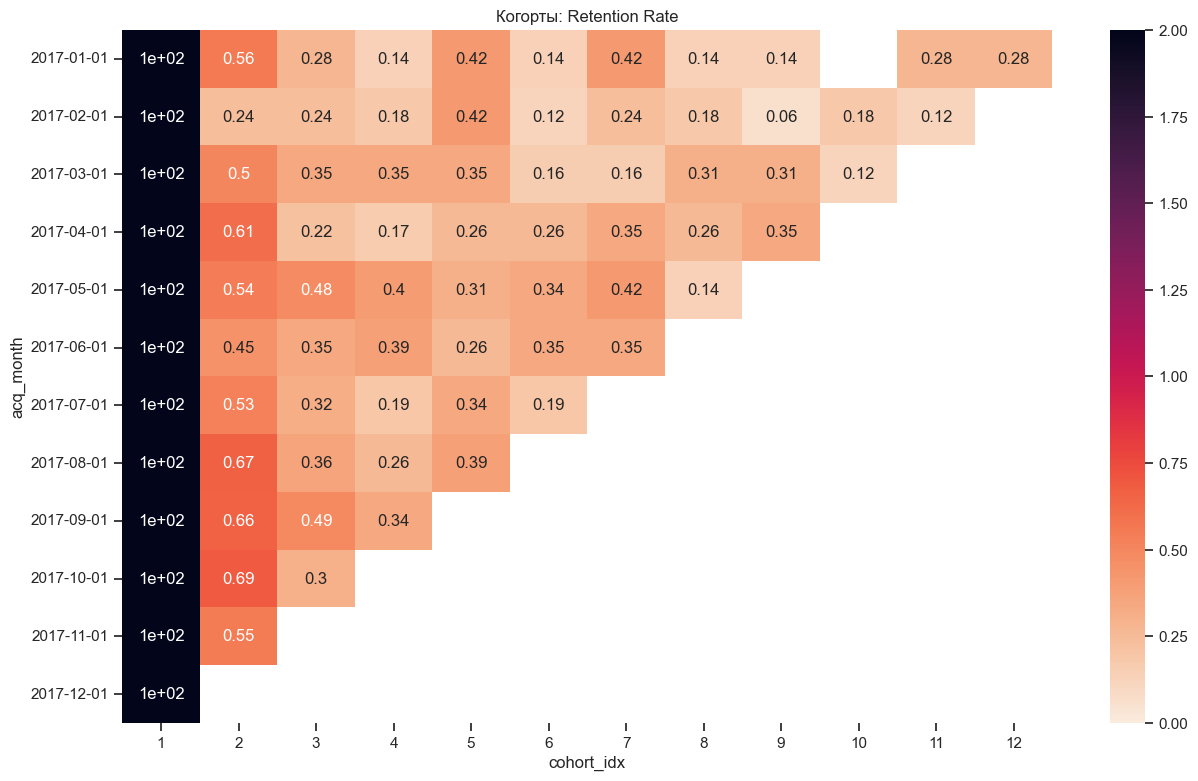

In [68]:
cmap = sns.cm.rocket_r
sns.set(style='ticks')
plt.figure(figsize=(15, 9))
plt.xlabel('Когорты')
plt.title('Когорты: Retention Rate')
sns.heatmap(retention, annot=True, cmap=cmap, vmin=0, vmax=2, center= 1)

### Ответ 5:

Когорта с самым высоким процентом удержания на 3-й месяц (49%) - **2017-09-01**

# 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [65]:
# посчитаем итоговую сумму заказа
sales_per_order = items.groupby('order_id', as_index = False).agg({'price':'sum'}).rename(columns={'price':'sales'})

In [66]:
# удалим ненужные колонки
df = purchases_all.drop(columns=['order_status', 'order_purchase_timestamp', 'order_delivered_carrier_date', 
                                   'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [67]:
# добавим к основнуму df значения суммы заказа
df_RFM = df.merge(sales_per_order, on = 'order_id')

In [68]:
# перевод даты в соответствующий формат
df_RFM['purchase_date'] = pd.to_datetime(df_RFM.order_approved_at).dt.date

In [69]:
df_RFM = df_RFM.drop(columns = ['order_approved_at','customer_id'])

In [70]:
df_RFM.head()

,order_id,customer_unique_id,sales,purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,118.70,2018-07-26
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [ ]:
# расчитаем recency как срок с последней покупки
df_recency = df_RFM.groupby('customer_unique_id', as_index = False)['purchase_date'].max() # дата последней покупки
df_recency.columns = ['customer_unique_id', 'last_purchase_date'] # создание колонок для df
recent_date = df_recency['last_purchase_date'].max() # последняя дата в df как текущая дата
df_recency['Recency'] = df_recency['last_purchase_date'] \
    .apply(lambda x: (recent_date - x).days) # подсчет recency для всех строк

In [ ]:
df_recency.head()

In [ ]:
# расчет количества покупок на клиенат
frequency_df = df_RFM.drop_duplicates().groupby('customer_unique_id', as_index = False)['purchase_date'].count()
frequency_df.columns = ['customer_unique_id', 'Frequency']
frequency_df.head()

In [ ]:
# сумма покупок на клиента уже расчитана как sales - сумма товаров, приобретенным одним клиентом
monetary_df = df_RFM.groupby('customer_unique_id', as_index = False) \
    .agg({'sales':'sum'})
monetary_df.head()

In [ ]:
# объединение таблиц в одну
rf_df = df_recency.merge(frequency_df, on='customer_unique_id') 
rfm_df = rf_df.merge(monetary_df, on='customer_unique_id') \
    .drop(columns='last_purchase_date') \
    .rename(columns={'sales':'Monetary'})
rfm_df.head()

In [ ]:
# используем разделенеие показателей на 5 равномерных частей для создания сегментов
quintiles = rfm_df[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

In [ ]:
rfm_df.Frequency.unique()

In [ ]:
rfm_df.query('Frequency != 1') # клиенты, совершившие более 1 покупки

In [ ]:
rfm_df.shape

Всего 2886 клиентов из 94970 совершили более 1 покупки, отчего не выйдет использовать метод 5 равных частей для сегментации показателя frequency.

In [ ]:
# определим группы для recency и monetary
# чем меньше значение recency, тем меньше времени прошло с покупки
# чем больше значение monetary, тем больше потратил клиент

def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['Monetary'][.2]: 
        return 1
    elif x <= quintiles['Monetary'][.4]:
        return 2
    elif x <= quintiles['Monetary'][.6]:
        return 3
    elif x <= quintiles['Monetary'][.8]:
        return 4
    else:
        return 5

# т.к. частота покупок в подавляющем числе случаев =1, границы показателя установлены более 1/ равно 1
def f_score(x):
    if x > 1:
        return 2
    else:
        return 1

In [ ]:
# применение функций для всех строк df
rfm_df['R_score'] = rfm_df['Recency'].apply(lambda x: r_score(x)) 
rfm_df['F_score'] = rfm_df['Frequency'].apply(lambda x: f_score(x))
rfm_df['M_score'] = rfm_df['Monetary'].apply(lambda x: m_score(x))

In [ ]:
rfm_df['RFM_score'] = rfm_df['R_score'].map(str) + rfm_df['F_score'].map(str) + rfm_df['M_score'].map(str)

In [ ]:
rfm_df.head(10)

### Ответ 6:
Клиент 0000366f3b9a7992bf8c76cfdf3221e2 имеет RFM_score = 414: сделал только 1 покупку менее 181 дня назад и принес компании более 109.9 у.е. (больше него принесли только 20% клиентов) 